#### This Version Creates the Graph in Neo4J then runs the Queries.

In [69]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

In [70]:
# Define the source directory
source_dir = os.path.abspath('../../data/graph_2_8')

# Define the destination directory
# This should be the import directory of your graph database
#Windows
#destination_dir = 'C:/Users/stang/.Neo4jDesktop/relate-data/dbmss/dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351/import'

#Linux
#destination_dir = '/home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-b10bd033-c28d-4fe4-aefd-32b992c43361/import'
destination_dir = '/home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import'

# Specify the filenames to move
filenames = ['nodes.csv', 'relationships.csv']

for filename in filenames:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)
    
    # Move each file
    shutil.copy(source_path, destination_path)

Then run the admin import command.

In [71]:
# Define the working directory
#Windows
#working_dir = 'C:/Users/stang/.Neo4jDesktop/relate-data/dbmss/dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351/bin'

#Linux
# working_dir = '/home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-b10bd033-c28d-4fe4-aefd-32b992c43361'
working_dir = '/home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a'

# Construct the command Linux
command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
]

#Windows
#command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'

# Execute the command


#result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/data/databases/neo4j:\nNodes:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/nodes.csv\n\nRelationships:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 13.49GiB\n  Free machine memory: 2.129GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 12\n  Configured max memory: 879.7MiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\nImport 

Run and connect to the Neo4j Database

In [72]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
password = os.environ['NEO4J_Password']           # Neo4J password
# password = '26622002'

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [73]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [74]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [75]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [76]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [77]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [78]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [79]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [80]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [81]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [82]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 2
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [83]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [84]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [85]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['name'], how='left')

In [86]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210401-1-09,2.146059,564.349921,4.222196e-02,0.181851,25,1451
1,210217-1-26,2.101379,561.363967,4.196559e-02,0.181666,25,1451
2,210217-1-27,2.101379,561.363967,4.196559e-02,0.181666,25,1451
3,210401-1-11,2.094687,560.527378,4.190058e-02,0.181618,25,1451
4,210401-1-10,2.088831,560.887273,4.191806e-02,0.181632,25,1451
...,...,...,...,...,...,...,...
3040,210526-3-45,0.150000,0.000000,3.176670e-20,0.150000,345,3040
3041,210526-3-46,0.150000,0.000000,3.176670e-20,0.150000,346,3041
3042,210526-3-47,0.150000,0.000000,3.176670e-20,0.150000,347,3042
3043,210526-3-48,0.150000,0.000000,3.176670e-20,0.150000,348,3043


In [87]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1
0,201210-1-00,-1.007253,0.897236
1,201210-1-01,-1.112249,0.739160
2,201210-1-02,-0.162728,1.932532
3,201210-1-03,-1.782401,0.449577
4,201210-1-04,-0.843528,0.984705


Delete the projection

In [88]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [89]:
close_driver()

In [90]:
status_df = pd.read_csv('../../data/graph_2_8/status.csv')

In [91]:
status_df.drop(columns=['Unnamed: 0'], inplace=True)

In [92]:
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210401-1-09,2.146059,564.349921,4.222196e-02,0.181851,25,1451
1,210217-1-26,2.101379,561.363967,4.196559e-02,0.181666,25,1451
2,210217-1-27,2.101379,561.363967,4.196559e-02,0.181666,25,1451
3,210401-1-11,2.094687,560.527378,4.190058e-02,0.181618,25,1451
4,210401-1-10,2.088831,560.887273,4.191806e-02,0.181632,25,1451
...,...,...,...,...,...,...,...
3040,210526-3-45,0.150000,0.000000,3.176670e-20,0.150000,345,3040
3041,210526-3-46,0.150000,0.000000,3.176670e-20,0.150000,346,3041
3042,210526-3-47,0.150000,0.000000,3.176670e-20,0.150000,347,3042
3043,210526-3-48,0.150000,0.000000,3.176670e-20,0.150000,348,3043


In [93]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
#graph_df.drop(columns=["SurID:ID"], inplace=True)

In [94]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
#fast_graph_df.drop(columns=["SurID:ID"], inplace=True)

In [95]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [96]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [97]:
fast_graph_df

,SpecID,embedding_0,embedding_1,Status,SurID
0,201210-1-00,-1.007253,0.897236,Normal,201210-1
1,201210-1-01,-1.112249,0.739160,Normal,201210-1
2,201210-1-02,-0.162728,1.932532,Normal,201210-1
3,201210-1-03,-1.782401,0.449577,Normal,201210-1
4,201210-1-04,-0.843528,0.984705,Normal,201210-1
...,...,...,...,...,...
3040,210526-3-45,0.000000,0.000000,Hyperglycemia,210526-3
3041,210526-3-46,0.000000,0.000000,Hyperglycemia,210526-3
3042,210526-3-47,0.000000,0.000000,Hyperglycemia,210526-3
3043,210526-3-48,0.000000,0.000000,Hyperglycemia,210526-3


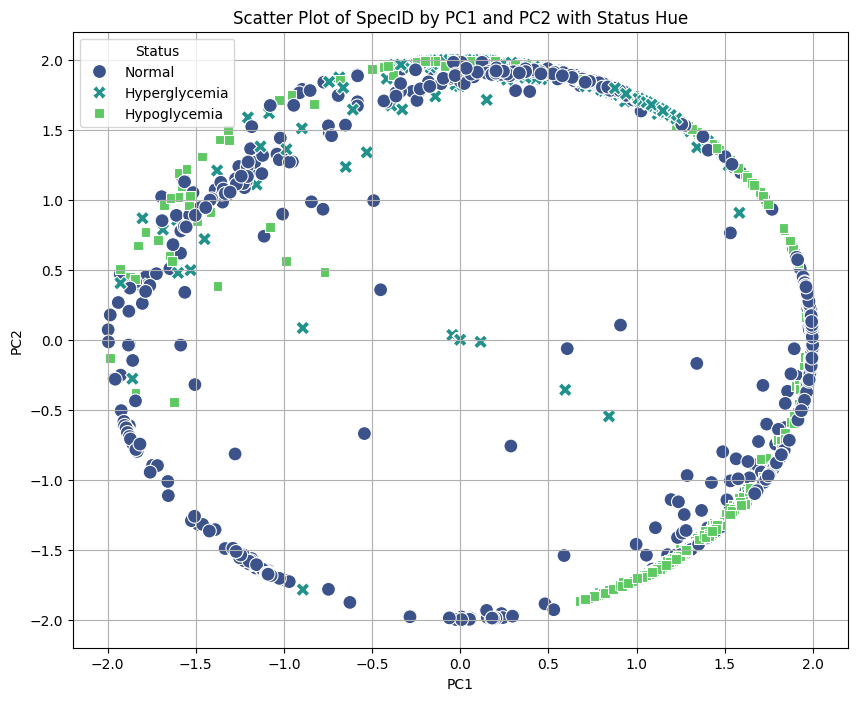

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=fast_graph_df, x="embedding_0", y="embedding_1", hue="Status", style="Status", s=100, palette="viridis")
plt.title("Scatter Plot of SpecID by PC1 and PC2 with Status Hue")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.grid(True)
plt.show()

In [99]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 2
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

pca = PCA(n_components=2)

X = fast_graph_df.drop(columns=['SpecID', 'Status', 'SurID'])
y = fast_graph_df[['SpecID', 'Status', 'SurID']]

reduced = pca.fit_transform(X.values)

df_reduced = pd.DataFrame(reduced, columns=['PC1', 'PC2'])

two_dim_df = pd.merge(df_reduced, y, left_index=True, right_index=True, how='inner')

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=two_dim_df, x="PC1", y="PC2", hue="SurID", s=100, palette="viridis", legend=False)
plt.title("Scatter Plot of SpecID by PC1 and PC2 with Status Hue")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.grid(True)
plt.show()

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.fastRP.stream`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.}

In [ ]:
evaluate_extra_trees(fast_graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3579 +/- 0.0587


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [ ]:
X = fast_graph_df.drop(columns=['SpecID', 'Status', 'SurID'])
y = fast_graph_df[['SpecID', 'Status', 'SurID']]

In [ ]:
reduced = pca.fit_transform(X.values)

In [ ]:
df_reduced = pd.DataFrame(reduced, columns=['PC1', 'PC2'])

In [ ]:
two_dim_df = pd.merge(df_reduced, y, left_index=True, right_index=True, how='inner')

In [ ]:
two_dim_df

,PC1,PC2,SpecID,Status,SurID
0,-0.723145,-0.257326,201210-1-00,Normal,201210-1
1,-0.724697,-0.217263,201210-1-01,Normal,201210-1
2,-0.711073,-0.054434,201210-1-02,Normal,201210-1
3,-0.120208,0.824839,201210-1-03,Normal,201210-1
4,-0.695874,0.002625,201210-1-04,Normal,201210-1
...,...,...,...,...,...
3040,-0.725148,-0.215229,210526-3-45,Hyperglycemia,210526-3
3041,-0.724987,-0.222123,210526-3-46,Hyperglycemia,210526-3
3042,-0.724716,-0.229973,210526-3-47,Hyperglycemia,210526-3
3043,-0.724269,-0.239615,210526-3-48,Hyperglycemia,210526-3


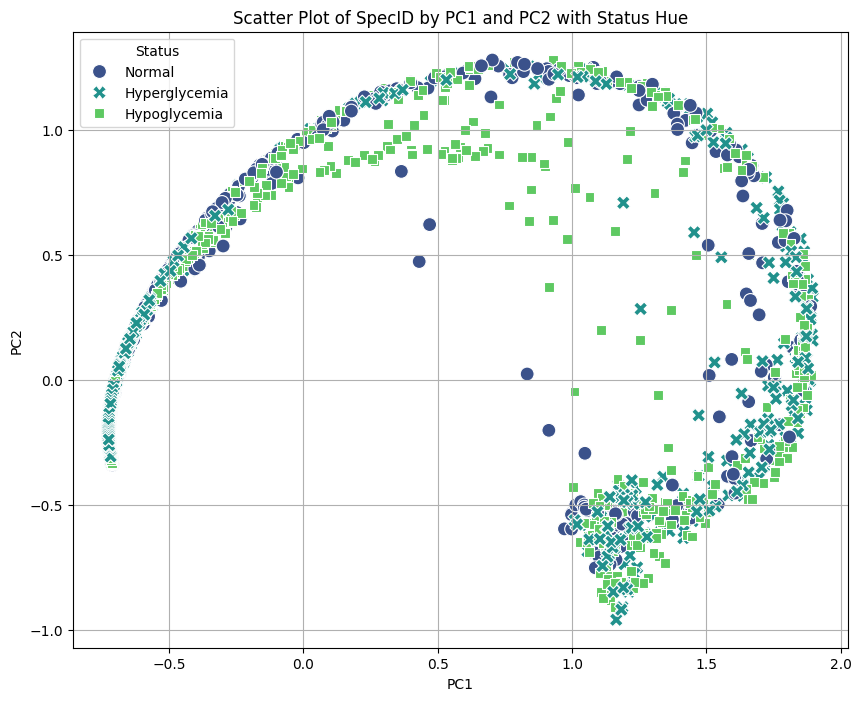

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=two_dim_df, x="PC1", y="PC2", hue="Status", style="Status", s=100, palette="viridis")
plt.title("Scatter Plot of SpecID by PC1 and PC2 with Status Hue")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.grid(True)
plt.show()

In [ ]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,Status,SurID
0,210510-2-43,9.995351,4.047927e-03,0.0,0.150000,14,2648,Hyperglycemia,210510-2
1,210504-1-29,8.274016,7.354992e-20,0.0,0.150000,22,2371,Hypoglycemia,210504-1
2,210510-2-33,8.136034,3.757366e-03,0.0,0.150000,14,2648,Hyperglycemia,210510-2
3,210504-1-06,7.417265,7.355337e-20,0.0,0.150000,175,2371,Hypoglycemia,210504-1
4,210315-1-43,6.588713,3.262992e-01,0.0,0.150014,99,1241,Hypoglycemia,210315-1
...,...,...,...,...,...,...,...,...,...
3040,210304-2-31,0.150000,1.253953e-68,0.0,0.150000,220,1010,Hypoglycemia,210304-2
3041,210324-2-34,0.150000,1.024505e-82,0.0,0.150000,56,347,Normal,210324-2
3042,210407-1-03,0.150000,1.143846e-68,0.0,0.150000,0,1703,Hypoglycemia,210407-1
3043,210407-1-32,0.150000,2.410214e-52,0.0,0.150000,99,1760,Hypoglycemia,210407-1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID', 'SpecID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [ ]:
evaluate_extra_trees(graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4234 +/- 0.0559


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = graph_df.drop(['Status', 'SurID'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.2357 +/- 0.2191
ExtraTreesClassifier Cross-Validation Accuracy: 0.2381 +/- 0.2564


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [ ]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [ ]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [ ]:
calculate_metrics(y_test, rf_predictions)

NameError: name 'y_test' is not defined

In [ ]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.3694581280788177


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.35      0.31      0.33       192
 Hypoglycemia       0.39      0.38      0.38       218
       Normal       0.37      0.42      0.39       199

     accuracy                           0.37       609
    macro avg       0.37      0.37      0.37       609
 weighted avg       0.37      0.37      0.37       609


Confusion Matrix:
[[60 65 67]
 [62 82 74]
 [51 65 83]]


In [ ]:
get_feature_importances(rf_model, X)

,Feature,Importance
0,PageRank,0.242765
1,DegreeCentrality,0.230733
3,ArticleRank,0.230634
2,EigenvectorCentrality,0.230235
4,Leiden,0.035406
5,Louvain,0.030227


In [ ]:
get_feature_importances(et_model, X)

,Feature,Importance
0,PageRank,0.240788
3,ArticleRank,0.235372
1,DegreeCentrality,0.234854
2,EigenvectorCentrality,0.230949
4,Leiden,0.031944
5,Louvain,0.026093


## FastRp

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status', 'SurID'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7241379310344828
Extra Trees Accuracy: 0.6929392446633826


In [ ]:
evaluate_extra_trees(fast_graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4234 +/- 0.0559


Fast rp mixed with traditional graph metrics

In [ ]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status', 'SurID'], how='inner')

In [ ]:
joined_graph

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,Status,SurID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7
0,210510-2-43,9.995351,4.047927e-03,0.0,0.150000,14,2648,Hyperglycemia,210510-2,-8.477771e-01,-5.664921e-01,4.399757e-02,5.512041e-02,-1.221743e-01,-6.573741e-01,-5.014504e-01,1.261413e-01
1,210504-1-29,8.274016,7.354992e-20,0.0,0.150000,22,2371,Hypoglycemia,210504-1,-2.837829e-30,-1.121170e-30,-1.407195e-29,-3.605064e-30,-4.515061e-31,2.726851e-30,2.127726e-30,6.832553e-30
2,210510-2-33,8.136034,3.757366e-03,0.0,0.150000,14,2648,Hyperglycemia,210510-2,-8.784710e-01,-5.237433e-01,4.056044e-02,1.115304e-01,-1.165270e-01,-6.124557e-01,-4.740078e-01,1.300640e-01
3,210504-1-06,7.417265,7.355337e-20,0.0,0.150000,175,2371,Hypoglycemia,210504-1,-3.606436e-27,-5.855427e-31,-1.346121e-26,-4.925807e-27,-1.822102e-31,4.925134e-27,4.924980e-27,4.928060e-27
4,210315-1-43,6.588713,3.262992e-01,0.0,0.150014,99,1241,Hypoglycemia,210315-1,-6.980112e-01,9.719404e-01,-2.392559e-01,-4.585312e-01,-3.894587e-01,5.456215e-02,1.033318e+00,1.532656e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210304-2-31,0.150000,1.253953e-68,0.0,0.150000,220,1010,Hypoglycemia,210304-2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3041,210324-2-34,0.150000,1.024505e-82,0.0,0.150000,56,347,Normal,210324-2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3042,210407-1-03,0.150000,1.143846e-68,0.0,0.150000,0,1703,Hypoglycemia,210407-1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3043,210407-1-32,0.150000,2.410214e-52,0.0,0.150000,99,1760,Hypoglycemia,210407-1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status', 'SurID'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.6153846153846154
Extra Trees Accuracy: 0.5384615384615384


In [ ]:
# Drop the SpecID column
X = joined_graph.drop(columns=['Status', 'SurID'])

# Target variable
y = joined_graph['Status']

# Creating the classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=1234)
et = ExtraTreesClassifier(n_estimators=100,random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.3238 +/- 0.1360
ExtraTreesClassifier Cross-Validation Accuracy: 0.4286 +/- 0.2244


In [ ]:
evaluate_extra_trees(joined_graph)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4527 +/- 0.0733
